In [1]:
using OrdinaryDiffEq
using Plots
using QuantumAnnealingTools

# Redfield equation with multi-axis couplings
In this example, we solve Redfield equation with the folowing Hamiltonian
\begin{equation}
    H(s) = - \sigma_z + \sigma_x \otimes B_1 + \sigma_z \otimes B_2 + H_\mathrm{B}
\end{equation}
where $B_1$ and $B_2$ are independent Ohmic bath with different cutoff frequencies. 

## Tutorial
First, we need to combine `AbstractCouplings` with `AbstractBath` into an `Interaction` object. Then we can combine different interactions into an `InteractionSet`.

In [2]:
coupling_1 = ConstantCouplings(["X"])
bath_1 = Ohmic(1e-4, 4, 16)
interaction_1 = Interaction(coupling_1, bath_1)

coupling_2 = ConstantCouplings(["Z"])
bath_2 = Ohmic(1e-4, 0.1, 16)
interaction_2 = Interaction(coupling_2, bath_2)

interaction_set = InteractionSet(interaction_1, interaction_2);

Finally, we can create `Annealing` object with `InteractionSet` instead of `coupling` and `bath`.

In [3]:
H = DenseHamiltonian([(s) -> 1.0], -[σz], unit = :ħ)
u0 = PauliVec[1][1]
annealing_1 = Annealing(H, u0, coupling=coupling_1, bath = bath_1)
annealing_2 = Annealing(H, u0, coupling=coupling_2, bath = bath_2)
annealing = Annealing(H, u0, interactions=interaction_set)

Annealing with hType DenseHamiltonian{Complex{Float64}} and uType Array{Complex{Float64},1}
u0 with size: (2,)

In [6]:
tf = 10
# Generate the unitary first
U = solve_unitary(annealing, tf, alg=Tsit5(), reltol=1e-6)
# tag the unitary so the solver know it has inplace update method
# this will speed up the calculation of integral
U = InplaceUnitary(U);

In the following block, we solve the Redfield equation with $X$, $Z$ and $X$ plus $Z$ couplings.

In [5]:
# Solve the Redfield equation
sol_1 = solve_redfield(annealing_1, tf, U, alg = Tsit5(), abstol = 1e-6, reltol = 1e-6)
sol_2 = solve_redfield(annealing_2, tf, U, alg = Tsit5(), abstol = 1e-6, reltol = 1e-6)
sol = solve_redfield(annealing, tf, U, alg = Tsit5(), abstol = 1e-6, reltol = 1e-6);

Then we plot $\langle X \rangle$ for all the different cases.

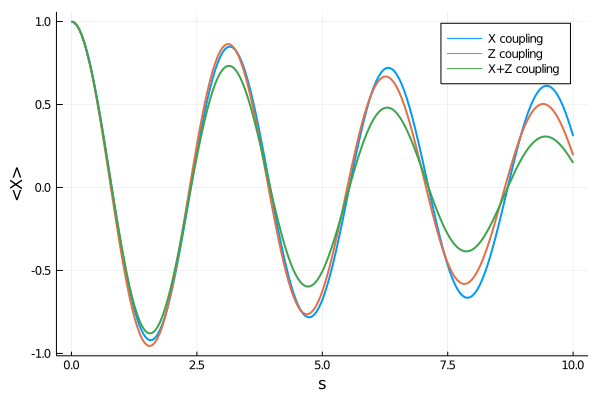

In [8]:
s_list = range(0,tf,length=200)
x1 = []
x2 = []
x = []
for s in s_list
    push!(x1, real(tr(σx*sol_1(s))))
    push!(x2, real(tr(σx*sol_2(s))))
    push!(x, real(tr(σx*sol(s))))
end
x_nopulse = x1
plot(s_list, x1, linewidth=2, label="X coupling")
plot!(s_list, x2, linewidth=2, label="Z coupling")
plot!(s_list, x, linewidth=2, label="X+Z coupling")
xlabel!("s")
ylabel!("<X>")

## Dynamical Decoupling
Finally, we run the same simulation with a single $X$ pulse in the middle of the evolution (spin echo). The can be done by creating a `Callback` object and feed it to the solver. For ideal DD, we can use the built-in function `InstPulseCallback`.

In [14]:
# the first argument is a list of times where the pulses are applied
# the second argument is a function to update the state 
# function (c, pulse_index) the function will update the state c with give pulse_index
# in this example, we apply an X pulse in the middle of the annealing
cb = InstPulseCallback([0.5 * tf], (c, x) -> c .= σx * c * σx)
annealing_1 = Annealing(H, u0, coupling = coupling_1, bath = bath_1)
annealing_2 = Annealing(H, u0, coupling=coupling_2, bath = bath_2)
annealing = Annealing(H, u0, interactions=interaction_set)

Annealing with hType DenseHamiltonian{Complex{Float64}} and uType Array{Complex{Float64},1}
u0 with size: (2,)

In [15]:
tf = 10
U = solve_unitary(annealing, tf, alg=Tsit5(), reltol=1e-6, callback = cb);
U = InplaceUnitary(U);

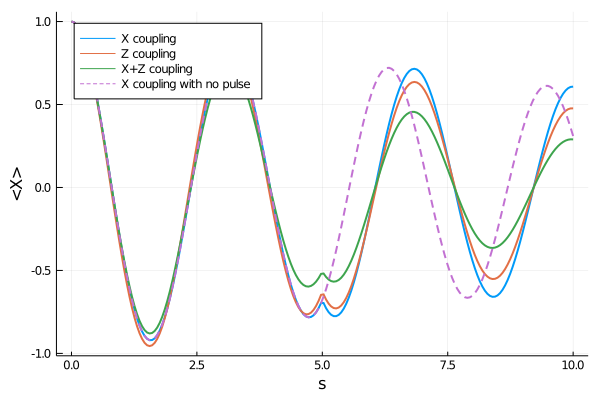

In [16]:
sol_1 = solve_redfield(annealing_1, tf, U, alg = Tsit5(), reltol = 1e-6, callback=cb)
sol_2 = solve_redfield(annealing_2, tf, U, alg = Tsit5(), reltol = 1e-6, callback=cb)
sol = solve_redfield(annealing, tf, U, alg = Tsit5(), reltol = 1e-6, callback=cb);
s_list = range(0,tf,length=200)
x1 = []
x2 = []
x = []
for s in s_list
    push!(x1, real(tr(σx*sol_1(s))))
    push!(x2, real(tr(σx*sol_2(s))))
    push!(x, real(tr(σx*sol(s))))
end
plot(s_list, x1, linewidth=2, label="X coupling", legend=:topleft)
plot!(s_list, x2, linewidth=2, label="Z coupling")
plot!(s_list, x, linewidth=2, label="X+Z coupling")
plot!(s_list, x_nopulse, linewidth=2, linestyle=:dash, label="X coupling with no pulse")
xlabel!("s")
ylabel!("<X>")